In [52]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from pydantic.experimental.pipeline import transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
plt.style.use('ggplot')

REZNET модель

In [46]:
model = models.resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [54]:
def reznet18_for_cifar10():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, num_classes)
    return model
    

In [55]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_batch_size = 256
test_batch_size = 256

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [56]:
model = reznet18_for_cifar10()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
num_epochs = 200

model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_accuracy = 0
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_correct = 0
    
    model.train()
    
    for images, labels in tqdm(train_loader, leave=True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        train_running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        
    train_loss = train_running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / len(train_set)
    train_accuracies.append(train_accuracy)
    
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            
    test_loss = test_running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = test_correct / len(test_set)
    test_accuracies.append(test_accuracy)
    print(f'Epoch: [{epoch+1}/{num_epochs}], train_loss = {train_loss:.4f}, train_acc = {train_accuracy:.4f}, test_loss = {test_loss:.4f}, test_accuracy = {test_accuracy:.4f}')
    
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        print('Сохранена новая лучшая модель')
        PATH = 'models/cifar_reznet_best.pth'
        torch.save(model.state_dict(), PATH)
print('Сохранена последняя модель')
PATH = 'models/cifar_reznet_last.pth'
torch.save(model.state_dict(), PATH)
print('Закончили обучение')

C:\Users\Devourer\AppData\Local\pypoetry\Cache\virtualenvs\ai-test-task-O710Er_i-py3.13\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 196/196 [00:38<00:00,  5.08it/s]


Epoch: [1/200], train_loss = 2.1089, train_acc = 0.2580, test_loss = 1.6905, test_accuracy = 0.3860
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:39<00:00,  5.01it/s]


Epoch: [2/200], train_loss = 1.5932, train_acc = 0.4120, test_loss = 1.4129, test_accuracy = 0.4782
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.10it/s]


Epoch: [3/200], train_loss = 1.3639, train_acc = 0.5027, test_loss = 1.1706, test_accuracy = 0.5723
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.09it/s]


Epoch: [4/200], train_loss = 1.1748, train_acc = 0.5794, test_loss = 1.3449, test_accuracy = 0.5612


100%|██████████| 196/196 [00:38<00:00,  5.14it/s]


Epoch: [5/200], train_loss = 1.0407, train_acc = 0.6299, test_loss = 1.0072, test_accuracy = 0.6460
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch: [6/200], train_loss = 0.9310, train_acc = 0.6700, test_loss = 0.9883, test_accuracy = 0.6485
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Epoch: [7/200], train_loss = 0.8300, train_acc = 0.7077, test_loss = 0.8849, test_accuracy = 0.6986
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch: [8/200], train_loss = 0.7470, train_acc = 0.7379, test_loss = 0.7368, test_accuracy = 0.7447
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.15it/s]


Epoch: [9/200], train_loss = 0.6864, train_acc = 0.7608, test_loss = 0.6510, test_accuracy = 0.7789
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.15it/s]


Epoch: [10/200], train_loss = 0.6342, train_acc = 0.7798, test_loss = 0.5977, test_accuracy = 0.7899
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:39<00:00,  4.98it/s]


Epoch: [11/200], train_loss = 0.5925, train_acc = 0.7952, test_loss = 0.6383, test_accuracy = 0.7847


100%|██████████| 196/196 [00:38<00:00,  5.04it/s]


Epoch: [12/200], train_loss = 0.5601, train_acc = 0.8033, test_loss = 0.5732, test_accuracy = 0.8030
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:39<00:00,  5.01it/s]


Epoch: [13/200], train_loss = 0.5368, train_acc = 0.8138, test_loss = 0.4815, test_accuracy = 0.8333
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.11it/s]


Epoch: [14/200], train_loss = 0.5124, train_acc = 0.8205, test_loss = 0.5273, test_accuracy = 0.8165


100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch: [15/200], train_loss = 0.4969, train_acc = 0.8258, test_loss = 0.7163, test_accuracy = 0.7667


100%|██████████| 196/196 [00:39<00:00,  4.92it/s]


Epoch: [16/200], train_loss = 0.4807, train_acc = 0.8332, test_loss = 0.5008, test_accuracy = 0.8285


100%|██████████| 196/196 [00:38<00:00,  5.11it/s]


Epoch: [17/200], train_loss = 0.4584, train_acc = 0.8426, test_loss = 0.4925, test_accuracy = 0.8333


100%|██████████| 196/196 [00:38<00:00,  5.09it/s]


Epoch: [18/200], train_loss = 0.4505, train_acc = 0.8438, test_loss = 0.4774, test_accuracy = 0.8351
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch: [19/200], train_loss = 0.4395, train_acc = 0.8478, test_loss = 0.5235, test_accuracy = 0.8248


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch: [20/200], train_loss = 0.4344, train_acc = 0.8512, test_loss = 0.6587, test_accuracy = 0.7792


100%|██████████| 196/196 [00:39<00:00,  4.97it/s]


Epoch: [21/200], train_loss = 0.4307, train_acc = 0.8524, test_loss = 0.4752, test_accuracy = 0.8362
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Epoch: [22/200], train_loss = 0.4162, train_acc = 0.8564, test_loss = 0.5593, test_accuracy = 0.8108


100%|██████████| 196/196 [00:38<00:00,  5.06it/s]


Epoch: [23/200], train_loss = 0.4049, train_acc = 0.8596, test_loss = 0.4201, test_accuracy = 0.8551
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.15it/s]


Epoch: [24/200], train_loss = 0.4012, train_acc = 0.8620, test_loss = 0.4338, test_accuracy = 0.8519


100%|██████████| 196/196 [00:38<00:00,  5.08it/s]


Epoch: [25/200], train_loss = 0.3938, train_acc = 0.8646, test_loss = 0.4393, test_accuracy = 0.8530


100%|██████████| 196/196 [00:39<00:00,  4.94it/s]


Epoch: [26/200], train_loss = 0.3889, train_acc = 0.8666, test_loss = 0.5454, test_accuracy = 0.8270


100%|██████████| 196/196 [00:38<00:00,  5.03it/s]


Epoch: [27/200], train_loss = 0.3849, train_acc = 0.8674, test_loss = 0.4152, test_accuracy = 0.8598
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:38<00:00,  5.08it/s]


Epoch: [28/200], train_loss = 0.3756, train_acc = 0.8709, test_loss = 0.5949, test_accuracy = 0.8134


100%|██████████| 196/196 [00:38<00:00,  5.13it/s]


Epoch: [29/200], train_loss = 0.3696, train_acc = 0.8717, test_loss = 0.4765, test_accuracy = 0.8407


100%|██████████| 196/196 [00:38<00:00,  5.06it/s]


Epoch: [30/200], train_loss = 0.3626, train_acc = 0.8742, test_loss = 0.4803, test_accuracy = 0.8448


100%|██████████| 196/196 [00:38<00:00,  5.16it/s]


Epoch: [31/200], train_loss = 0.3596, train_acc = 0.8757, test_loss = 0.4704, test_accuracy = 0.8417


100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch: [32/200], train_loss = 0.3548, train_acc = 0.8773, test_loss = 0.4225, test_accuracy = 0.8622
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:45<00:00,  4.35it/s]


Epoch: [33/200], train_loss = 0.3551, train_acc = 0.8770, test_loss = 0.4979, test_accuracy = 0.8418


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch: [34/200], train_loss = 0.3479, train_acc = 0.8794, test_loss = 0.4503, test_accuracy = 0.8540


100%|██████████| 196/196 [00:43<00:00,  4.46it/s]


Epoch: [35/200], train_loss = 0.3502, train_acc = 0.8793, test_loss = 0.4014, test_accuracy = 0.8713
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:45<00:00,  4.29it/s]


Epoch: [36/200], train_loss = 0.3460, train_acc = 0.8813, test_loss = 0.4320, test_accuracy = 0.8647


100%|██████████| 196/196 [00:43<00:00,  4.54it/s]


Epoch: [37/200], train_loss = 0.3381, train_acc = 0.8840, test_loss = 0.4630, test_accuracy = 0.8513


100%|██████████| 196/196 [00:42<00:00,  4.57it/s]


Epoch: [38/200], train_loss = 0.3402, train_acc = 0.8825, test_loss = 0.4724, test_accuracy = 0.8376


100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


Epoch: [39/200], train_loss = 0.3387, train_acc = 0.8827, test_loss = 0.4390, test_accuracy = 0.8541


100%|██████████| 196/196 [00:42<00:00,  4.56it/s]


Epoch: [40/200], train_loss = 0.3344, train_acc = 0.8834, test_loss = 0.4838, test_accuracy = 0.8470


100%|██████████| 196/196 [00:43<00:00,  4.49it/s]


Epoch: [41/200], train_loss = 0.3319, train_acc = 0.8861, test_loss = 0.4723, test_accuracy = 0.8453


100%|██████████| 196/196 [00:44<00:00,  4.38it/s]


Epoch: [42/200], train_loss = 0.3280, train_acc = 0.8877, test_loss = 0.4525, test_accuracy = 0.8540


100%|██████████| 196/196 [00:47<00:00,  4.14it/s]


Epoch: [43/200], train_loss = 0.3218, train_acc = 0.8902, test_loss = 0.3908, test_accuracy = 0.8728
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [44/200], train_loss = 0.3278, train_acc = 0.8870, test_loss = 0.4857, test_accuracy = 0.8423


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [45/200], train_loss = 0.3193, train_acc = 0.8895, test_loss = 0.3781, test_accuracy = 0.8719


100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch: [46/200], train_loss = 0.3177, train_acc = 0.8899, test_loss = 0.4179, test_accuracy = 0.8621


100%|██████████| 196/196 [00:41<00:00,  4.77it/s]


Epoch: [47/200], train_loss = 0.3199, train_acc = 0.8901, test_loss = 0.4460, test_accuracy = 0.8535


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [48/200], train_loss = 0.3134, train_acc = 0.8920, test_loss = 0.5240, test_accuracy = 0.8288


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [49/200], train_loss = 0.3169, train_acc = 0.8917, test_loss = 0.3715, test_accuracy = 0.8737
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [50/200], train_loss = 0.3074, train_acc = 0.8950, test_loss = 0.5285, test_accuracy = 0.8314


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [51/200], train_loss = 0.3148, train_acc = 0.8926, test_loss = 0.4788, test_accuracy = 0.8457


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [52/200], train_loss = 0.3083, train_acc = 0.8930, test_loss = 0.5609, test_accuracy = 0.8253


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [53/200], train_loss = 0.3060, train_acc = 0.8952, test_loss = 0.4165, test_accuracy = 0.8648


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [54/200], train_loss = 0.3130, train_acc = 0.8910, test_loss = 0.3918, test_accuracy = 0.8730


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [55/200], train_loss = 0.3064, train_acc = 0.8949, test_loss = 0.3968, test_accuracy = 0.8741
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [56/200], train_loss = 0.2988, train_acc = 0.8979, test_loss = 0.4224, test_accuracy = 0.8692


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [57/200], train_loss = 0.3056, train_acc = 0.8960, test_loss = 0.3966, test_accuracy = 0.8684


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [58/200], train_loss = 0.3062, train_acc = 0.8934, test_loss = 0.4798, test_accuracy = 0.8499


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [59/200], train_loss = 0.3053, train_acc = 0.8946, test_loss = 0.3857, test_accuracy = 0.8747
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [60/200], train_loss = 0.3009, train_acc = 0.8975, test_loss = 0.4520, test_accuracy = 0.8514


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [61/200], train_loss = 0.3054, train_acc = 0.8940, test_loss = 0.5064, test_accuracy = 0.8340


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [62/200], train_loss = 0.3004, train_acc = 0.8967, test_loss = 0.4536, test_accuracy = 0.8561


100%|██████████| 196/196 [00:42<00:00,  4.64it/s]


Epoch: [63/200], train_loss = 0.3007, train_acc = 0.8955, test_loss = 0.4479, test_accuracy = 0.8545


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [64/200], train_loss = 0.3022, train_acc = 0.8955, test_loss = 0.4283, test_accuracy = 0.8623


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [65/200], train_loss = 0.2927, train_acc = 0.8992, test_loss = 0.3275, test_accuracy = 0.8914
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [66/200], train_loss = 0.2995, train_acc = 0.8952, test_loss = 0.4204, test_accuracy = 0.8615


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [67/200], train_loss = 0.2985, train_acc = 0.8964, test_loss = 0.3503, test_accuracy = 0.8840


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [68/200], train_loss = 0.3014, train_acc = 0.8961, test_loss = 0.4295, test_accuracy = 0.8491


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [69/200], train_loss = 0.2966, train_acc = 0.8977, test_loss = 0.3884, test_accuracy = 0.8738


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [70/200], train_loss = 0.2951, train_acc = 0.8979, test_loss = 0.3868, test_accuracy = 0.8724


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [71/200], train_loss = 0.2915, train_acc = 0.8993, test_loss = 0.4200, test_accuracy = 0.8637


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [72/200], train_loss = 0.2973, train_acc = 0.8974, test_loss = 0.4491, test_accuracy = 0.8586


100%|██████████| 196/196 [00:40<00:00,  4.83it/s]


Epoch: [73/200], train_loss = 0.2912, train_acc = 0.8996, test_loss = 0.5072, test_accuracy = 0.8383


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [74/200], train_loss = 0.2938, train_acc = 0.8988, test_loss = 0.4906, test_accuracy = 0.8480


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [75/200], train_loss = 0.2863, train_acc = 0.9003, test_loss = 0.3764, test_accuracy = 0.8769


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [76/200], train_loss = 0.2884, train_acc = 0.8994, test_loss = 0.4155, test_accuracy = 0.8639


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [77/200], train_loss = 0.2965, train_acc = 0.8981, test_loss = 0.3625, test_accuracy = 0.8851


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [78/200], train_loss = 0.2954, train_acc = 0.8978, test_loss = 0.6085, test_accuracy = 0.8134


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [79/200], train_loss = 0.2882, train_acc = 0.9001, test_loss = 0.3894, test_accuracy = 0.8788


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [80/200], train_loss = 0.2877, train_acc = 0.9006, test_loss = 0.3250, test_accuracy = 0.8936
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.75it/s]


Epoch: [81/200], train_loss = 0.2779, train_acc = 0.9041, test_loss = 0.3449, test_accuracy = 0.8860


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [82/200], train_loss = 0.2874, train_acc = 0.9028, test_loss = 0.4918, test_accuracy = 0.8364


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [83/200], train_loss = 0.2901, train_acc = 0.9003, test_loss = 0.3608, test_accuracy = 0.8829


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [84/200], train_loss = 0.2860, train_acc = 0.9017, test_loss = 0.4177, test_accuracy = 0.8658


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [85/200], train_loss = 0.2849, train_acc = 0.9016, test_loss = 0.3618, test_accuracy = 0.8799


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [86/200], train_loss = 0.2839, train_acc = 0.9023, test_loss = 0.4045, test_accuracy = 0.8707


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Epoch: [87/200], train_loss = 0.2824, train_acc = 0.9029, test_loss = 0.4645, test_accuracy = 0.8568


100%|██████████| 196/196 [00:41<00:00,  4.73it/s]


Epoch: [88/200], train_loss = 0.2913, train_acc = 0.9002, test_loss = 0.4387, test_accuracy = 0.8592


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [89/200], train_loss = 0.2832, train_acc = 0.9030, test_loss = 0.3939, test_accuracy = 0.8733


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [90/200], train_loss = 0.2794, train_acc = 0.9031, test_loss = 0.4344, test_accuracy = 0.8616


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [91/200], train_loss = 0.2781, train_acc = 0.9031, test_loss = 0.4505, test_accuracy = 0.8592


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Epoch: [92/200], train_loss = 0.2854, train_acc = 0.9020, test_loss = 0.4101, test_accuracy = 0.8668


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [93/200], train_loss = 0.2856, train_acc = 0.9014, test_loss = 0.4133, test_accuracy = 0.8686


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [94/200], train_loss = 0.2807, train_acc = 0.9028, test_loss = 0.4069, test_accuracy = 0.8708


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [95/200], train_loss = 0.2871, train_acc = 0.9017, test_loss = 0.4222, test_accuracy = 0.8578


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [96/200], train_loss = 0.2825, train_acc = 0.9017, test_loss = 0.4103, test_accuracy = 0.8711


100%|██████████| 196/196 [00:41<00:00,  4.74it/s]


Epoch: [97/200], train_loss = 0.2749, train_acc = 0.9052, test_loss = 0.4593, test_accuracy = 0.8498


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Epoch: [98/200], train_loss = 0.2779, train_acc = 0.9049, test_loss = 0.3194, test_accuracy = 0.8957
Сохранена новая лучшая модель


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [99/200], train_loss = 0.2810, train_acc = 0.9031, test_loss = 0.3923, test_accuracy = 0.8723


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [100/200], train_loss = 0.2820, train_acc = 0.9026, test_loss = 0.3894, test_accuracy = 0.8722


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [101/200], train_loss = 0.2833, train_acc = 0.9008, test_loss = 0.3552, test_accuracy = 0.8850


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [102/200], train_loss = 0.2821, train_acc = 0.9031, test_loss = 0.5003, test_accuracy = 0.8501


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Epoch: [103/200], train_loss = 0.2811, train_acc = 0.9049, test_loss = 0.4352, test_accuracy = 0.8622


100%|██████████| 196/196 [00:42<00:00,  4.59it/s]


Epoch: [104/200], train_loss = 0.2804, train_acc = 0.9036, test_loss = 0.3757, test_accuracy = 0.8795


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [105/200], train_loss = 0.2831, train_acc = 0.9031, test_loss = 0.3556, test_accuracy = 0.8864


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [106/200], train_loss = 0.2753, train_acc = 0.9052, test_loss = 0.4155, test_accuracy = 0.8636


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [107/200], train_loss = 0.2800, train_acc = 0.9033, test_loss = 0.3749, test_accuracy = 0.8762


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [108/200], train_loss = 0.2690, train_acc = 0.9073, test_loss = 0.4393, test_accuracy = 0.8600


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [109/200], train_loss = 0.2822, train_acc = 0.9042, test_loss = 0.4562, test_accuracy = 0.8518


100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


Epoch: [110/200], train_loss = 0.2793, train_acc = 0.9049, test_loss = 0.3573, test_accuracy = 0.8801


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [111/200], train_loss = 0.2750, train_acc = 0.9049, test_loss = 0.3876, test_accuracy = 0.8700


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [112/200], train_loss = 0.2790, train_acc = 0.9039, test_loss = 0.4590, test_accuracy = 0.8528


100%|██████████| 196/196 [00:41<00:00,  4.75it/s]


Epoch: [113/200], train_loss = 0.2754, train_acc = 0.9048, test_loss = 0.3819, test_accuracy = 0.8733


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [114/200], train_loss = 0.2738, train_acc = 0.9055, test_loss = 0.4021, test_accuracy = 0.8776


100%|██████████| 196/196 [00:42<00:00,  4.59it/s]


Epoch: [115/200], train_loss = 0.2768, train_acc = 0.9041, test_loss = 0.3416, test_accuracy = 0.8871


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [116/200], train_loss = 0.2804, train_acc = 0.9027, test_loss = 0.3839, test_accuracy = 0.8719


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [117/200], train_loss = 0.2740, train_acc = 0.9066, test_loss = 0.3525, test_accuracy = 0.8850


100%|██████████| 196/196 [00:43<00:00,  4.53it/s]


Epoch: [118/200], train_loss = 0.2824, train_acc = 0.9018, test_loss = 0.4177, test_accuracy = 0.8683


100%|██████████| 196/196 [00:42<00:00,  4.57it/s]


Epoch: [119/200], train_loss = 0.2730, train_acc = 0.9074, test_loss = 0.3559, test_accuracy = 0.8837


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [120/200], train_loss = 0.2769, train_acc = 0.9054, test_loss = 0.4681, test_accuracy = 0.8595


100%|██████████| 196/196 [00:42<00:00,  4.62it/s]


Epoch: [121/200], train_loss = 0.2763, train_acc = 0.9046, test_loss = 0.4133, test_accuracy = 0.8693


100%|██████████| 196/196 [00:42<00:00,  4.58it/s]


Epoch: [122/200], train_loss = 0.2697, train_acc = 0.9069, test_loss = 0.4612, test_accuracy = 0.8532


100%|██████████| 196/196 [00:43<00:00,  4.52it/s]


Epoch: [123/200], train_loss = 0.2711, train_acc = 0.9073, test_loss = 0.4125, test_accuracy = 0.8711


100%|██████████| 196/196 [00:43<00:00,  4.56it/s]


Epoch: [124/200], train_loss = 0.2712, train_acc = 0.9066, test_loss = 0.4263, test_accuracy = 0.8607


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [125/200], train_loss = 0.2705, train_acc = 0.9055, test_loss = 0.4117, test_accuracy = 0.8652


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [126/200], train_loss = 0.2747, train_acc = 0.9064, test_loss = 0.5624, test_accuracy = 0.8239


100%|██████████| 196/196 [00:42<00:00,  4.60it/s]


Epoch: [127/200], train_loss = 0.2750, train_acc = 0.9051, test_loss = 0.3853, test_accuracy = 0.8692


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [128/200], train_loss = 0.2705, train_acc = 0.9066, test_loss = 0.3902, test_accuracy = 0.8752


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [129/200], train_loss = 0.2727, train_acc = 0.9064, test_loss = 0.3846, test_accuracy = 0.8747


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [130/200], train_loss = 0.2729, train_acc = 0.9050, test_loss = 0.4432, test_accuracy = 0.8651


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [131/200], train_loss = 0.2710, train_acc = 0.9074, test_loss = 0.3805, test_accuracy = 0.8766


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [132/200], train_loss = 0.2726, train_acc = 0.9079, test_loss = 0.4662, test_accuracy = 0.8564


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [133/200], train_loss = 0.2764, train_acc = 0.9065, test_loss = 0.3756, test_accuracy = 0.8828


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [134/200], train_loss = 0.2696, train_acc = 0.9064, test_loss = 0.4950, test_accuracy = 0.8432


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [135/200], train_loss = 0.2776, train_acc = 0.9048, test_loss = 0.3443, test_accuracy = 0.8860


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [136/200], train_loss = 0.2740, train_acc = 0.9046, test_loss = 0.3741, test_accuracy = 0.8800


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [137/200], train_loss = 0.2661, train_acc = 0.9081, test_loss = 0.4013, test_accuracy = 0.8712


100%|██████████| 196/196 [00:42<00:00,  4.64it/s]


Epoch: [138/200], train_loss = 0.2714, train_acc = 0.9066, test_loss = 0.4215, test_accuracy = 0.8685


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [139/200], train_loss = 0.2667, train_acc = 0.9084, test_loss = 0.3972, test_accuracy = 0.8739


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [140/200], train_loss = 0.2687, train_acc = 0.9079, test_loss = 0.4168, test_accuracy = 0.8687


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [141/200], train_loss = 0.2752, train_acc = 0.9049, test_loss = 0.5351, test_accuracy = 0.8369


100%|██████████| 196/196 [00:41<00:00,  4.77it/s]


Epoch: [142/200], train_loss = 0.2707, train_acc = 0.9074, test_loss = 0.4072, test_accuracy = 0.8662


100%|██████████| 196/196 [00:41<00:00,  4.67it/s]


Epoch: [143/200], train_loss = 0.2641, train_acc = 0.9092, test_loss = 0.4098, test_accuracy = 0.8728


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [144/200], train_loss = 0.2749, train_acc = 0.9063, test_loss = 0.4122, test_accuracy = 0.8697


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [145/200], train_loss = 0.2719, train_acc = 0.9059, test_loss = 0.3487, test_accuracy = 0.8950


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [146/200], train_loss = 0.2680, train_acc = 0.9076, test_loss = 0.3910, test_accuracy = 0.8746


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [147/200], train_loss = 0.2697, train_acc = 0.9058, test_loss = 0.4171, test_accuracy = 0.8621


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [148/200], train_loss = 0.2671, train_acc = 0.9072, test_loss = 0.3936, test_accuracy = 0.8716


100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Epoch: [149/200], train_loss = 0.2622, train_acc = 0.9088, test_loss = 0.4518, test_accuracy = 0.8600


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [150/200], train_loss = 0.2719, train_acc = 0.9081, test_loss = 0.3985, test_accuracy = 0.8723


100%|██████████| 196/196 [00:41<00:00,  4.73it/s]


Epoch: [151/200], train_loss = 0.2696, train_acc = 0.9081, test_loss = 0.3760, test_accuracy = 0.8784


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [152/200], train_loss = 0.2680, train_acc = 0.9085, test_loss = 0.3864, test_accuracy = 0.8752


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [153/200], train_loss = 0.2575, train_acc = 0.9121, test_loss = 0.3680, test_accuracy = 0.8789


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [154/200], train_loss = 0.2748, train_acc = 0.9063, test_loss = 0.3527, test_accuracy = 0.8860


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [155/200], train_loss = 0.2708, train_acc = 0.9069, test_loss = 0.3347, test_accuracy = 0.8918


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [156/200], train_loss = 0.2651, train_acc = 0.9082, test_loss = 0.3947, test_accuracy = 0.8739


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [157/200], train_loss = 0.2653, train_acc = 0.9095, test_loss = 0.4173, test_accuracy = 0.8679


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [158/200], train_loss = 0.2736, train_acc = 0.9042, test_loss = 0.3219, test_accuracy = 0.8956


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [159/200], train_loss = 0.2660, train_acc = 0.9085, test_loss = 0.3620, test_accuracy = 0.8854


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [160/200], train_loss = 0.2667, train_acc = 0.9090, test_loss = 0.4882, test_accuracy = 0.8455


100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Epoch: [161/200], train_loss = 0.2676, train_acc = 0.9074, test_loss = 0.4883, test_accuracy = 0.8391


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [162/200], train_loss = 0.2697, train_acc = 0.9073, test_loss = 0.3450, test_accuracy = 0.8892


100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Epoch: [163/200], train_loss = 0.2727, train_acc = 0.9056, test_loss = 0.4029, test_accuracy = 0.8704


100%|██████████| 196/196 [00:42<00:00,  4.60it/s]


Epoch: [164/200], train_loss = 0.2660, train_acc = 0.9093, test_loss = 0.4507, test_accuracy = 0.8581


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [165/200], train_loss = 0.2672, train_acc = 0.9081, test_loss = 0.3543, test_accuracy = 0.8870


100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Epoch: [166/200], train_loss = 0.2650, train_acc = 0.9097, test_loss = 0.3963, test_accuracy = 0.8739


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [167/200], train_loss = 0.2597, train_acc = 0.9095, test_loss = 0.3850, test_accuracy = 0.8760


100%|██████████| 196/196 [00:42<00:00,  4.64it/s]


Epoch: [168/200], train_loss = 0.2695, train_acc = 0.9087, test_loss = 0.3709, test_accuracy = 0.8799


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [169/200], train_loss = 0.2653, train_acc = 0.9092, test_loss = 0.3665, test_accuracy = 0.8864


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [170/200], train_loss = 0.2650, train_acc = 0.9083, test_loss = 0.5824, test_accuracy = 0.8245


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [171/200], train_loss = 0.2725, train_acc = 0.9062, test_loss = 0.3244, test_accuracy = 0.8928


100%|██████████| 196/196 [00:42<00:00,  4.58it/s]


Epoch: [172/200], train_loss = 0.2623, train_acc = 0.9089, test_loss = 0.4218, test_accuracy = 0.8694


100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Epoch: [173/200], train_loss = 0.2699, train_acc = 0.9072, test_loss = 0.4611, test_accuracy = 0.8539


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [174/200], train_loss = 0.2669, train_acc = 0.9081, test_loss = 0.4008, test_accuracy = 0.8741


100%|██████████| 196/196 [00:42<00:00,  4.67it/s]


Epoch: [175/200], train_loss = 0.2624, train_acc = 0.9087, test_loss = 0.3317, test_accuracy = 0.8922


100%|██████████| 196/196 [00:41<00:00,  4.73it/s]


Epoch: [176/200], train_loss = 0.2684, train_acc = 0.9081, test_loss = 0.3858, test_accuracy = 0.8795


100%|██████████| 196/196 [00:42<00:00,  4.65it/s]


Epoch: [177/200], train_loss = 0.2627, train_acc = 0.9088, test_loss = 0.3932, test_accuracy = 0.8719


100%|██████████| 196/196 [00:42<00:00,  4.60it/s]


Epoch: [178/200], train_loss = 0.2710, train_acc = 0.9061, test_loss = 0.3618, test_accuracy = 0.8814


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [179/200], train_loss = 0.2669, train_acc = 0.9090, test_loss = 0.4003, test_accuracy = 0.8710


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [180/200], train_loss = 0.2700, train_acc = 0.9068, test_loss = 0.3918, test_accuracy = 0.8760


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [181/200], train_loss = 0.2708, train_acc = 0.9072, test_loss = 0.3631, test_accuracy = 0.8859


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [182/200], train_loss = 0.2667, train_acc = 0.9094, test_loss = 0.3544, test_accuracy = 0.8834


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [183/200], train_loss = 0.2648, train_acc = 0.9089, test_loss = 0.3984, test_accuracy = 0.8732


100%|██████████| 196/196 [00:42<00:00,  4.58it/s]


Epoch: [184/200], train_loss = 0.2620, train_acc = 0.9096, test_loss = 0.3932, test_accuracy = 0.8724


100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


Epoch: [185/200], train_loss = 0.2640, train_acc = 0.9089, test_loss = 0.3569, test_accuracy = 0.8905


100%|██████████| 196/196 [00:44<00:00,  4.37it/s]


Epoch: [186/200], train_loss = 0.2682, train_acc = 0.9070, test_loss = 0.4448, test_accuracy = 0.8596


100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


Epoch: [187/200], train_loss = 0.2603, train_acc = 0.9108, test_loss = 0.4863, test_accuracy = 0.8456


100%|██████████| 196/196 [00:42<00:00,  4.61it/s]


Epoch: [188/200], train_loss = 0.2699, train_acc = 0.9078, test_loss = 0.3905, test_accuracy = 0.8727


100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Epoch: [189/200], train_loss = 0.2709, train_acc = 0.9072, test_loss = 0.3278, test_accuracy = 0.8926


100%|██████████| 196/196 [00:44<00:00,  4.40it/s]


Epoch: [190/200], train_loss = 0.2667, train_acc = 0.9085, test_loss = 0.4036, test_accuracy = 0.8716


100%|██████████| 196/196 [00:42<00:00,  4.57it/s]


Epoch: [191/200], train_loss = 0.2590, train_acc = 0.9093, test_loss = 0.3775, test_accuracy = 0.8822


100%|██████████| 196/196 [00:42<00:00,  4.58it/s]


Epoch: [192/200], train_loss = 0.2617, train_acc = 0.9104, test_loss = 0.3218, test_accuracy = 0.8928


100%|██████████| 196/196 [00:43<00:00,  4.56it/s]


Epoch: [193/200], train_loss = 0.2652, train_acc = 0.9098, test_loss = 0.4250, test_accuracy = 0.8651


100%|██████████| 196/196 [00:42<00:00,  4.57it/s]


Epoch: [194/200], train_loss = 0.2656, train_acc = 0.9095, test_loss = 0.3417, test_accuracy = 0.8921


100%|██████████| 196/196 [00:42<00:00,  4.59it/s]


Epoch: [195/200], train_loss = 0.2695, train_acc = 0.9083, test_loss = 0.3697, test_accuracy = 0.8805


100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


Epoch: [196/200], train_loss = 0.2613, train_acc = 0.9105, test_loss = 0.3524, test_accuracy = 0.8868


100%|██████████| 196/196 [00:40<00:00,  4.88it/s]


Epoch: [197/200], train_loss = 0.2670, train_acc = 0.9084, test_loss = 0.4684, test_accuracy = 0.8520


100%|██████████| 196/196 [00:41<00:00,  4.76it/s]


Epoch: [198/200], train_loss = 0.2636, train_acc = 0.9104, test_loss = 0.3750, test_accuracy = 0.8763


100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch: [199/200], train_loss = 0.2623, train_acc = 0.9094, test_loss = 0.3910, test_accuracy = 0.8747


100%|██████████| 196/196 [00:42<00:00,  4.63it/s]


Epoch: [200/200], train_loss = 0.2588, train_acc = 0.9109, test_loss = 0.4592, test_accuracy = 0.8525
Сохранена последняя модель
Закончили обучение


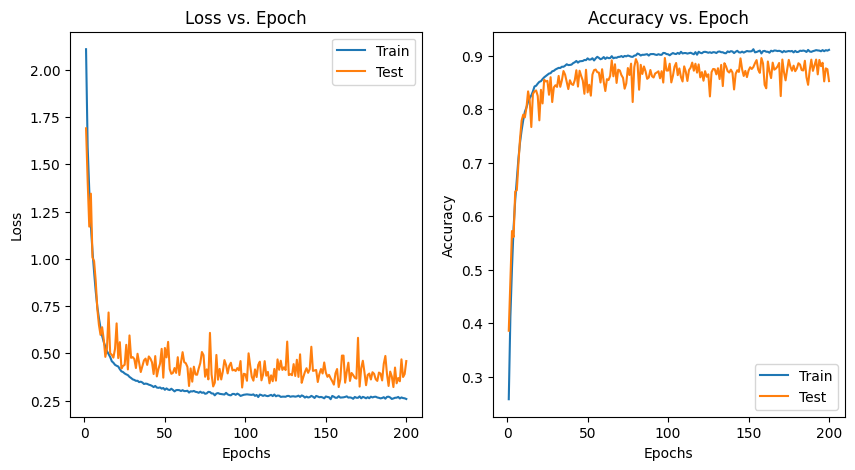

In [63]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label = 'Train')
plt.plot(range(1, num_epochs+1), test_losses, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label = 'Train')
plt.plot(range(1,num_epochs+1), test_accuracies, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [58]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(mode, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_conflusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion matrix')
        plt.show()

Метрики для текущей модели: 
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      5000
           1       0.94      0.96      0.95      5000
           2       0.88      0.89      0.88      5000
           3       0.78      0.84      0.81      5000
           4       0.91      0.89      0.90      5000
           5       0.89      0.80      0.84      5000
           6       0.92      0.91      0.91      5000
           7       0.86      0.96      0.91      5000
           8       0.97      0.90      0.93      5000
           9       0.92      0.95      0.93      5000

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

Test accuracy: 0.8958


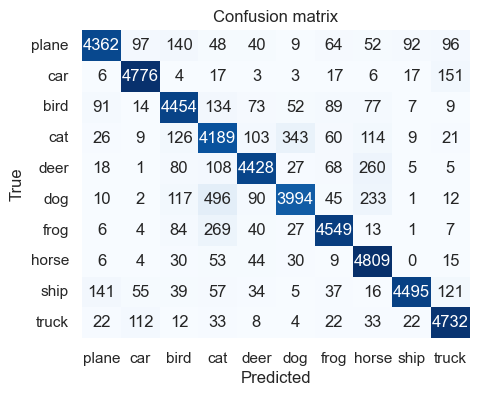

In [61]:
    model.load_state_dict(torch.load('models/cifar_reznet_best.pth'))
model.to(device)

cm, report, accuracy, weighted_f1 = evaluate_model(model, train_loader)
print('Метрики для текущей модели: ')
print(report)
print(f'Test accuracy: {accuracy:.4f}')
plot_conflusion_matrix(cm, classes)